In [1]:
# 1️⃣ Cargar datos
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Configuración para Visual Studio Code
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

print("=" * 60)
print("TASK 2: SIMPLE SALES FORECAST WITH MOVING AVERAGE")
print("=" * 60)

# Definir rutas
base_dir = r"C:\Users\Mario Leyser\PROYECTO_BASE\Interboot\INTERBOOT"
processed_path = os.path.join(base_dir, "data", "processed")
plots_path = os.path.join(base_dir, "plots")
models_path = os.path.join(base_dir, "models")

# Crear directorios necesarios
os.makedirs(models_path, exist_ok=True)
os.makedirs(plots_path, exist_ok=True)

# Cargar datos limpios del Task 1
try:
    clean_data_path = os.path.join(processed_path, 'sales_data_cleaned.csv')
    df = pd.read_csv(clean_data_path, parse_dates=['date'])
    print("✓ Datos limpios cargados exitosamente")
    print(f"Dimensiones: {df.shape}")
except FileNotFoundError:
    print("No se encontraron datos limpios. Cargando datos originales...")
    # Si no existen datos limpios, cargar y limpiar los originales
    raw_path = os.path.join(base_dir, "data", "raw", "train.csv")
    df = pd.read_csv(raw_path, parse_dates=['date'])
    print("✓ Datos originales cargados")

print(f"\nPeriodo de datos: {df['date'].min()} to {df['date'].max()}")

# Preparar datos para análisis de series temporales
print("\n" + "=" * 60)
print("PREPARANDO DATOS PARA ANÁLISIS DE SERIES TEMPORALES")
print("=" * 60)

# Agrupar ventas por fecha (ventas diarias totales)
daily_sales = df.groupby('date')['sales'].sum().reset_index()
daily_sales = daily_sales.sort_values('date')
daily_sales = daily_sales.set_index('date')

print(f"Ventas diarias totales: {len(daily_sales)} días")
print(f"Rango: {daily_sales.index.min()} to {daily_sales.index.max()}")

# Calcular algunas estadísticas básicas
print(f"\nEstadísticas de ventas diarias:")
print(f"• Promedio diario: ${daily_sales['sales'].mean():,.2f}")
print(f"• Mediana diaria: ${daily_sales['sales'].median():,.2f}")
print(f"• Desviación estándar: ${daily_sales['sales'].std():,.2f}")
print(f"• Máximo diario: ${daily_sales['sales'].max():,.2f}")
print(f"• Mínimo diario: ${daily_sales['sales'].min():,.2f}")


TASK 2: SIMPLE SALES FORECAST WITH MOVING AVERAGE
✓ Datos limpios cargados exitosamente
Dimensiones: (3000888, 9)

Periodo de datos: 2013-01-01 00:00:00 to 2017-08-15 00:00:00

PREPARANDO DATOS PARA ANÁLISIS DE SERIES TEMPORALES
Ventas diarias totales: 1684 días
Rango: 2013-01-01 00:00:00 to 2017-08-15 00:00:00

Estadísticas de ventas diarias:
• Promedio diario: $637,556.38
• Mediana diaria: $632,188.86
• Desviación estándar: $234,410.24
• Máximo diario: $1,463,083.96
• Mínimo diario: $2,511.62


In [2]:

# 2️⃣ Calcular medias móviles
print("\n" + "=" * 60)
print("CALCULANDO MEDIAS MÓVILES")
print("=" * 60)

# Crear una copia para trabajar
sales_ts = daily_sales.copy()

# Medias móviles para diferentes ventanas temporales
windows = {
    '7_days': 7,      # Semanal
    '14_days': 14,    # Bisemanal
    '30_days': 30,    # Mensual
    '60_days': 60,    # Bimestral
    '90_days': 90     # Trimestral
}

print("Calculando medias móviles...")
for name, window in windows.items():
    sales_ts[f'ma_{name}'] = sales_ts['sales'].rolling(window=window, center=False).mean()
    print(f"✓ Media móvil {window} días ({name}): calculada")

# Media móvil exponencial (da más peso a observaciones recientes)
sales_ts['ema_7'] = sales_ts['sales'].ewm(span=7, adjust=False).mean()
sales_ts['ema_30'] = sales_ts['sales'].ewm(span=30, adjust=False).mean()
print("✓ Medias móviles exponenciales calculadas")

# Calcular métricas de error para las medias móviles
def calculate_metrics(actual, predicted):
    """Calcular métricas de error"""
    mask = ~np.isnan(predicted)
    actual = actual[mask]
    predicted = predicted[mask]
    
    if len(actual) == 0:
        return np.nan, np.nan, np.nan
    
    mae = np.mean(np.abs(actual - predicted))
    mse = np.mean((actual - predicted) ** 2)
    rmse = np.sqrt(mse)
    
    return mae, mse, rmse

# Calcular métricas para cada media móvil
metrics_results = {}
for col in sales_ts.columns:
    if col.startswith('ma_') or col.startswith('ema_'):
        mae, mse, rmse = calculate_metrics(sales_ts['sales'].values, sales_ts[col].values)
        metrics_results[col] = {
            'MAE': mae,
            'MSE': mse, 
            'RMSE': rmse
        }

print("\nMétricas de error para medias móviles:")
for method, metrics in metrics_results.items():
    if not np.isnan(metrics['RMSE']):
        print(f"  {method:10}: RMSE = ${metrics['RMSE']:,.2f}")

# Preparar datos para forecasting
# Dividir en train y test (últimos 30 días para test)
test_days = 30
train_data = sales_ts.iloc[:-test_days]
test_data = sales_ts.iloc[-test_days:]

print(f"\nDivisión train/test:")
print(f"• Período de entrenamiento: {len(train_data)} días")
print(f"• Período de prueba: {len(test_data)} días")
print(f"• Fechas test: {test_data.index.min()} to {test_data.index.max()}")

# Forecasting simple usando la última media móvil disponible
last_ma_7 = train_data['ma_7_days'].iloc[-1]
last_ma_30 = train_data['ma_30_days'].iloc[-1]

# Crear pronósticos naive (usando la última media móvil disponible)
forecast_ma_7 = [last_ma_7] * test_days
forecast_ma_30 = [last_ma_30] * test_days



CALCULANDO MEDIAS MÓVILES
Calculando medias móviles...
✓ Media móvil 7 días (7_days): calculada
✓ Media móvil 14 días (14_days): calculada
✓ Media móvil 30 días (30_days): calculada
✓ Media móvil 60 días (60_days): calculada
✓ Media móvil 90 días (90_days): calculada
✓ Medias móviles exponenciales calculadas

Métricas de error para medias móviles:
  ma_7_days : RMSE = $138,030.54
  ma_14_days: RMSE = $145,104.31
  ma_30_days: RMSE = $148,521.83
  ma_60_days: RMSE = $158,432.80
  ma_90_days: RMSE = $162,442.45
  ema_7     : RMSE = $115,224.08
  ema_30    : RMSE = $143,956.09

División train/test:
• Período de entrenamiento: 1654 días
• Período de prueba: 30 días
• Fechas test: 2017-07-17 00:00:00 to 2017-08-15 00:00:00



VISUALIZANDO TENDENCIAS Y PRONÓSTICOS


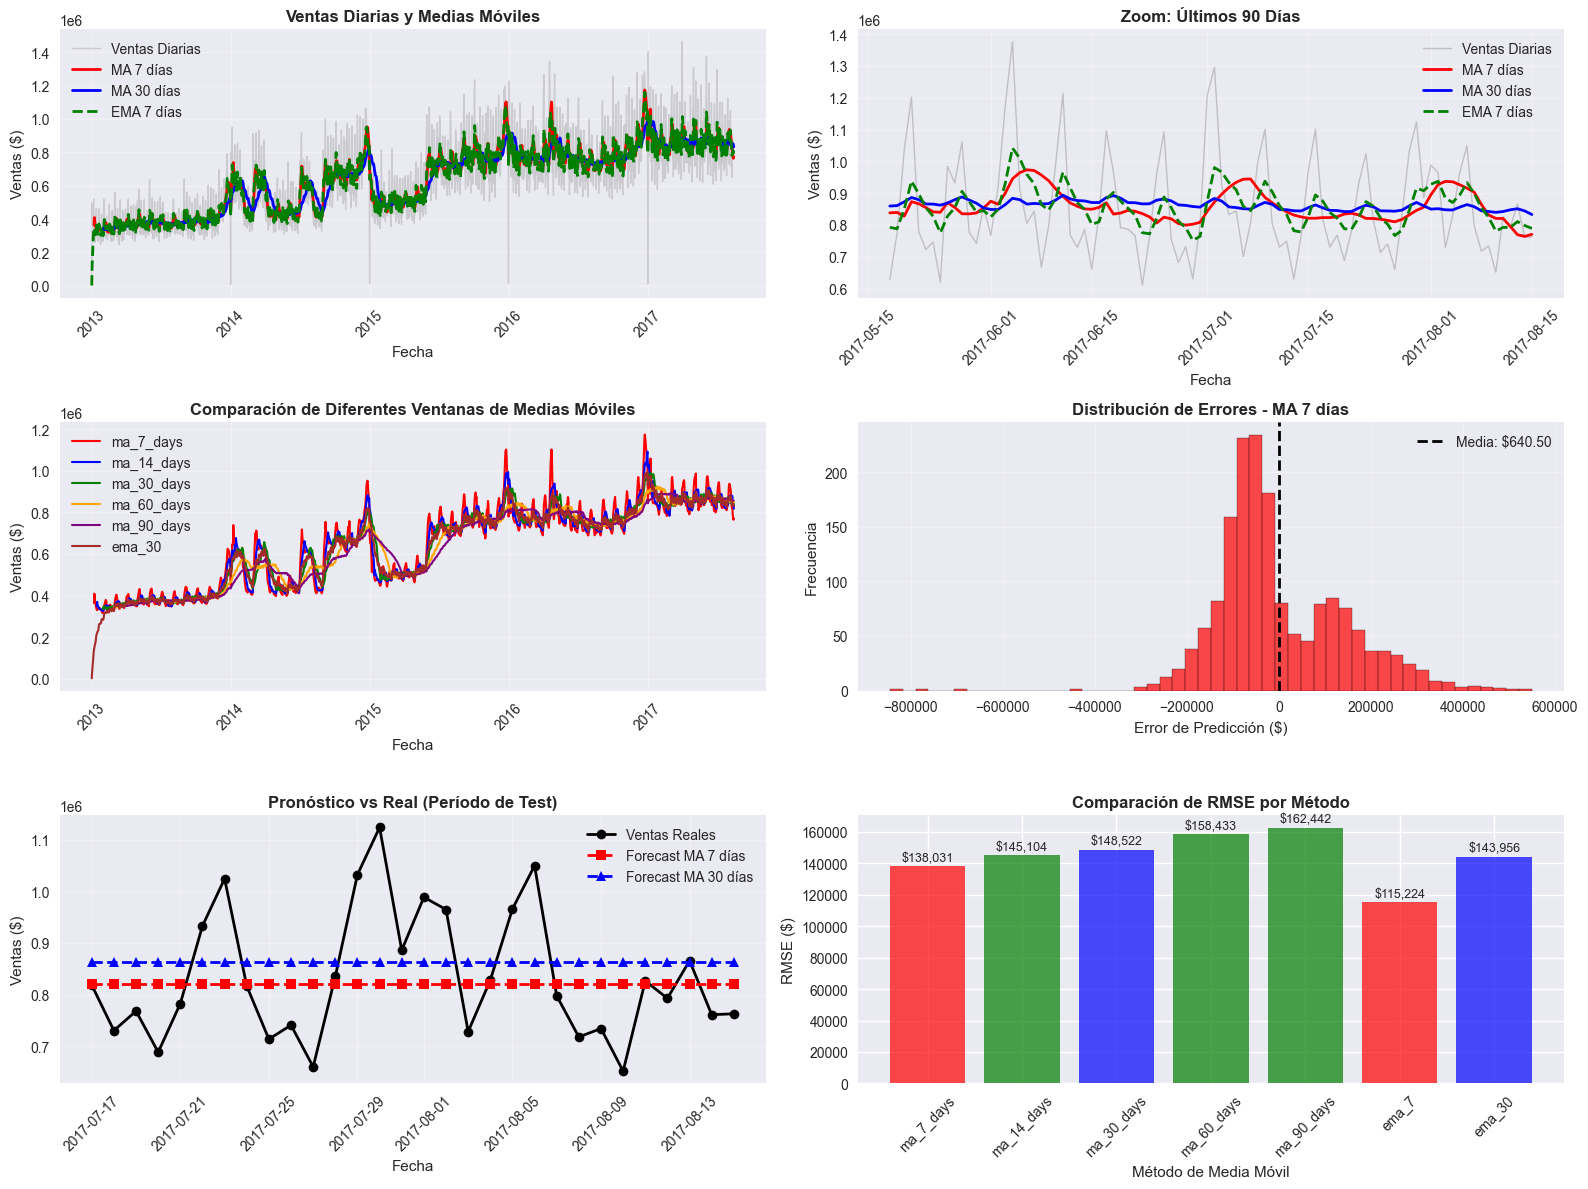

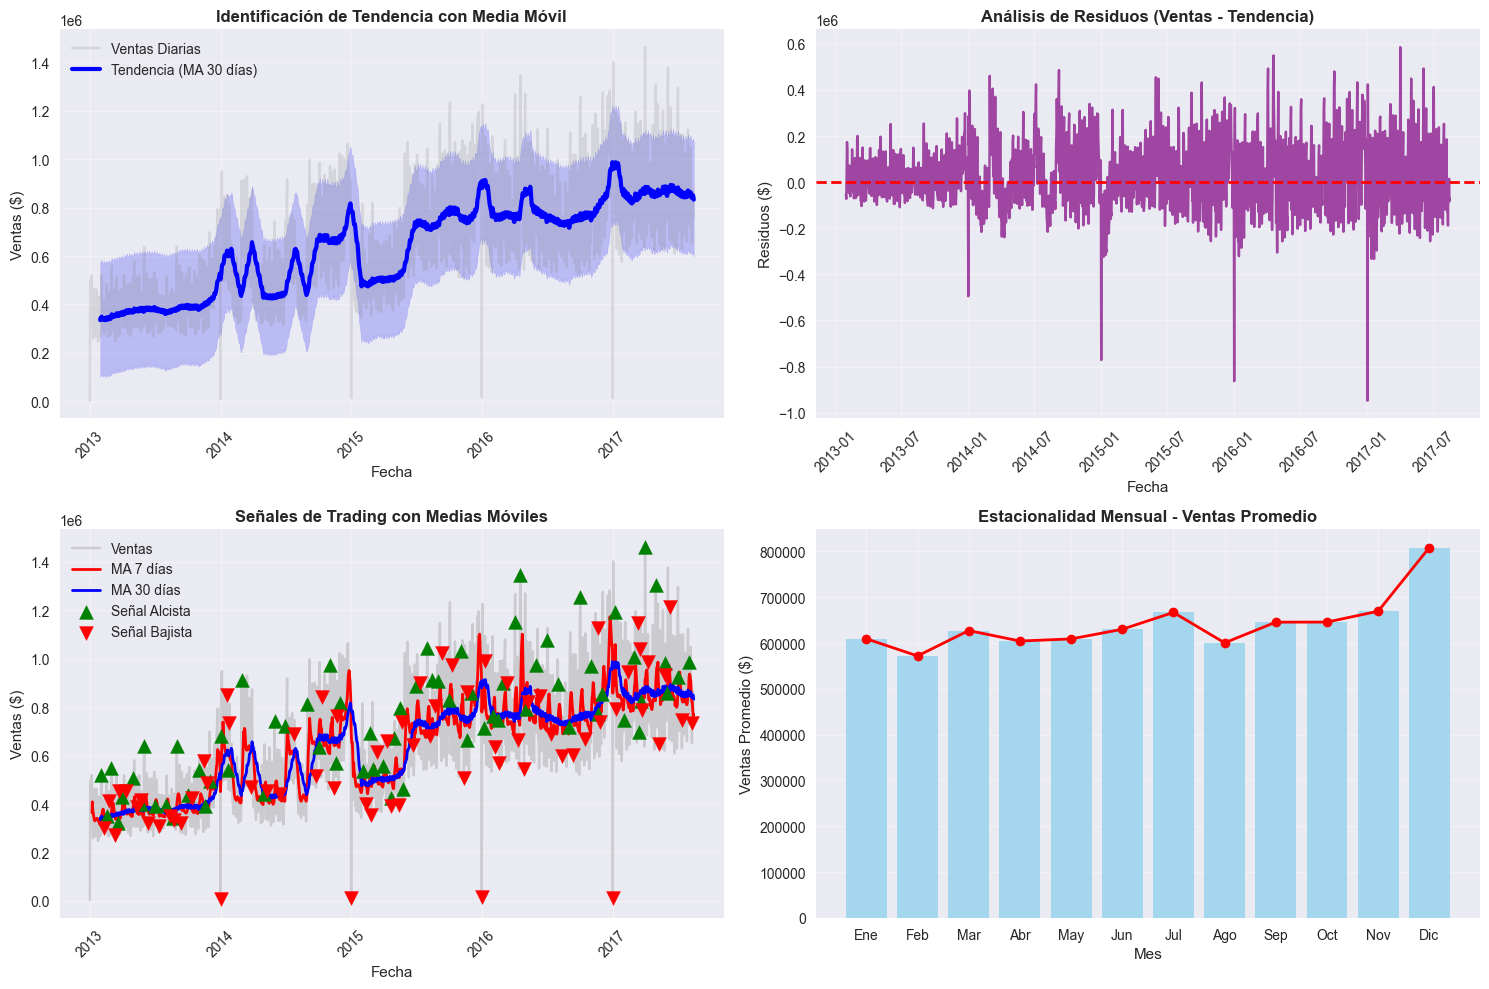


GUARDANDO RESULTADOS
✓ Dataset con medias móviles guardado: C:\Users\Mario Leyser\PROYECTO_BASE\Interboot\INTERBOOT\data\processed\sales_with_moving_averages.csv
✓ Métricas de medias móviles guardadas: C:\Users\Mario Leyser\PROYECTO_BASE\Interboot\INTERBOOT\data\processed\moving_average_metrics.csv

Guardando gráficas...
✓ Gráfica de tendencias guardada: C:\Users\Mario Leyser\PROYECTO_BASE\Interboot\INTERBOOT\plots\moving_averages_trend.png
✓ Gráfica de forecast guardada: C:\Users\Mario Leyser\PROYECTO_BASE\Interboot\INTERBOOT\plots\forecast_vs_actual.png

RESUMEN EJECUTIVO - MOVING AVERAGE FORECAST

📊 RESULTADOS PRINCIPALES:
   • Período analizado: 1684 días
   • Ventas diarias promedio: $637,556.38
   • Mejor media móvil (menor RMSE): ema_7

🎯 INSIGHTS DE MEDIAS MÓVILES:
   • Media móvil 7 días: Suaviza el ruido, buena para tendencias cortas
   • Media móvil 30 días: Mejor para identificar tendencias a largo plazo
   • EMA (Exponential MA): Responde más rápido a cambios recientes
  

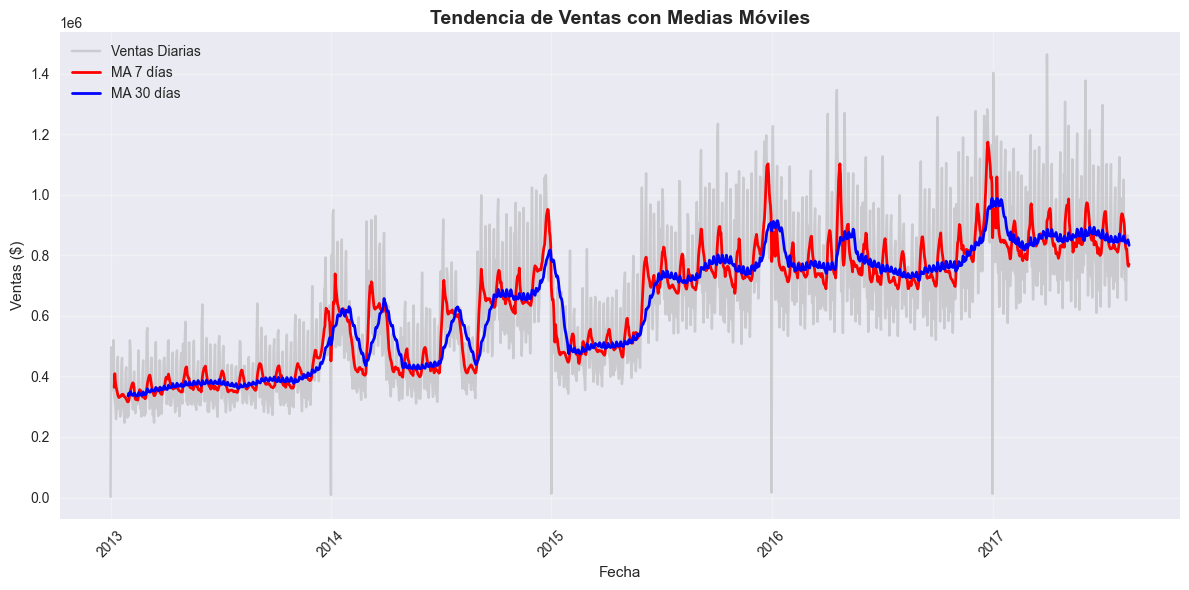

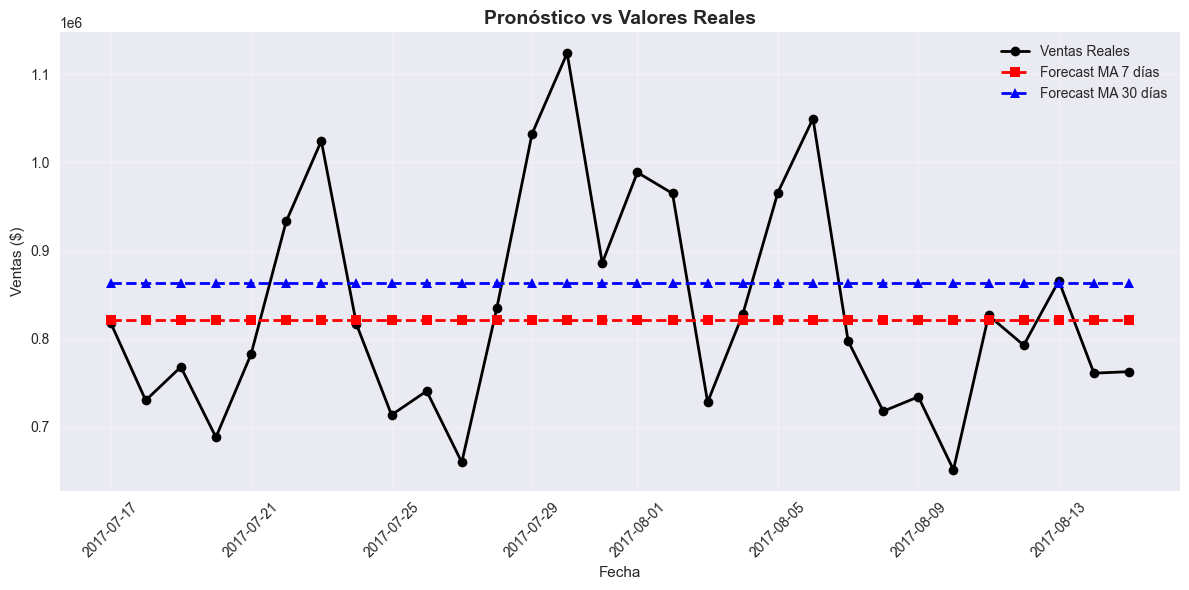

In [3]:

# 3️⃣ Visualizar tendencia
print("\n" + "=" * 60)
print("VISUALIZANDO TENDENCIAS Y PRONÓSTICOS")
print("=" * 60)

# Visualización 1: Comparación de diferentes medias móviles
plt.figure(figsize=(16, 12))

# 1.1 Serie original vs medias móviles (todo el período)
plt.subplot(3, 2, 1)
plt.plot(sales_ts.index, sales_ts['sales'], alpha=0.3, color='gray', label='Ventas Diarias', linewidth=1)
plt.plot(sales_ts.index, sales_ts['ma_7_days'], color='red', linewidth=2, label='MA 7 días')
plt.plot(sales_ts.index, sales_ts['ma_30_days'], color='blue', linewidth=2, label='MA 30 días')
plt.plot(sales_ts.index, sales_ts['ema_7'], color='green', linewidth=2, label='EMA 7 días', linestyle='--')
plt.title('Ventas Diarias y Medias Móviles', fontweight='bold', fontsize=12)
plt.xlabel('Fecha')
plt.ylabel('Ventas ($)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

# 1.2 Zoom en los últimos 90 días
plt.subplot(3, 2, 2)
recent_data = sales_ts.tail(90)
plt.plot(recent_data.index, recent_data['sales'], alpha=0.4, color='gray', label='Ventas Diarias', linewidth=1)
plt.plot(recent_data.index, recent_data['ma_7_days'], color='red', linewidth=2, label='MA 7 días')
plt.plot(recent_data.index, recent_data['ma_30_days'], color='blue', linewidth=2, label='MA 30 días')
plt.plot(recent_data.index, recent_data['ema_7'], color='green', linewidth=2, label='EMA 7 días', linestyle='--')
plt.title('Zoom: Últimos 90 Días', fontweight='bold', fontsize=12)
plt.xlabel('Fecha')
plt.ylabel('Ventas ($)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

# 1.3 Comparación de todas las medias móviles
plt.subplot(3, 2, 3)
colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown']
for i, (name, color) in enumerate(zip(['ma_7_days', 'ma_14_days', 'ma_30_days', 'ma_60_days', 'ma_90_days', 'ema_30'], colors)):
    plt.plot(sales_ts.index, sales_ts[name], color=color, linewidth=1.5, label=name)
plt.title('Comparación de Diferentes Ventanas de Medias Móviles', fontweight='bold', fontsize=12)
plt.xlabel('Fecha')
plt.ylabel('Ventas ($)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

# 1.4 Distribución de errores (MA 7 días)
plt.subplot(3, 2, 4)
errors_ma7 = sales_ts['sales'] - sales_ts['ma_7_days']
errors_ma7 = errors_ma7.dropna()
plt.hist(errors_ma7, bins=50, alpha=0.7, color='red', edgecolor='black')
plt.axvline(errors_ma7.mean(), color='black', linestyle='--', linewidth=2, label=f'Media: ${errors_ma7.mean():.2f}')
plt.title('Distribución de Errores - MA 7 días', fontweight='bold', fontsize=12)
plt.xlabel('Error de Predicción ($)')
plt.ylabel('Frecuencia')
plt.legend()
plt.grid(True, alpha=0.3)

# 1.5 Forecast vs Actual (período de test)
plt.subplot(3, 2, 5)
plt.plot(test_data.index, test_data['sales'], color='black', linewidth=2, label='Ventas Reales', marker='o')
plt.plot(test_data.index, forecast_ma_7, color='red', linewidth=2, label='Forecast MA 7 días', linestyle='--', marker='s')
plt.plot(test_data.index, forecast_ma_30, color='blue', linewidth=2, label='Forecast MA 30 días', linestyle='--', marker='^')
plt.title('Pronóstico vs Real (Período de Test)', fontweight='bold', fontsize=12)
plt.xlabel('Fecha')
plt.ylabel('Ventas ($)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

# 1.6 Métricas de error comparativas
plt.subplot(3, 2, 6)
methods = []
rmse_values = []
for method, metrics in metrics_results.items():
    if not np.isnan(metrics['RMSE']):
        methods.append(method)
        rmse_values.append(metrics['RMSE'])

if methods:
    colors = ['red' if '7' in method else 'blue' if '30' in method else 'green' for method in methods]
    bars = plt.bar(methods, rmse_values, color=colors, alpha=0.7)
    plt.title('Comparación de RMSE por Método', fontweight='bold', fontsize=12)
    plt.xlabel('Método de Media Móvil')
    plt.ylabel('RMSE ($)')
    plt.xticks(rotation=45)
    
    # Añadir valores en las barras
    for bar, value in zip(bars, rmse_values):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(rmse_values)*0.01, 
                f'${value:,.0f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

# Visualización 2: Análisis de tendencias y estacionalidad
plt.figure(figsize=(15, 10))

# 2.1 Tendencia con media móvil de 30 días
plt.subplot(2, 2, 1)
plt.plot(sales_ts.index, sales_ts['sales'], alpha=0.2, color='gray', label='Ventas Diarias')
plt.plot(sales_ts.index, sales_ts['ma_30_days'], color='blue', linewidth=3, label='Tendencia (MA 30 días)')
plt.fill_between(sales_ts.index, sales_ts['ma_30_days'] - sales_ts['sales'].std(), 
                 sales_ts['ma_30_days'] + sales_ts['sales'].std(), alpha=0.2, color='blue')
plt.title('Identificación de Tendencia con Media Móvil', fontweight='bold', fontsize=12)
plt.xlabel('Fecha')
plt.ylabel('Ventas ($)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

# 2.2 Análisis de residuos (ventas - tendencia)
plt.subplot(2, 2, 2)
residuals = sales_ts['sales'] - sales_ts['ma_30_days']
residuals = residuals.dropna()
plt.plot(residuals.index, residuals.values, color='purple', alpha=0.7)
plt.axhline(y=0, color='red', linestyle='--', linewidth=2)
plt.title('Análisis de Residuos (Ventas - Tendencia)', fontweight='bold', fontsize=12)
plt.xlabel('Fecha')
plt.ylabel('Residuos ($)')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

# 2.3 Media móvil adaptativa (comparación de ventanas)
plt.subplot(2, 2, 3)
short_window = 7
long_window = 30

# Señal de trading simple: cuando MA corta cruza por encima de MA larga
buy_signal = (sales_ts[f'ma_{short_window}_days'] > sales_ts[f'ma_{long_window}_days']) & \
             (sales_ts[f'ma_{short_window}_days'].shift(1) <= sales_ts[f'ma_{long_window}_days'].shift(1))

sell_signal = (sales_ts[f'ma_{short_window}_days'] < sales_ts[f'ma_{long_window}_days']) & \
              (sales_ts[f'ma_{short_window}_days'].shift(1) >= sales_ts[f'ma_{long_window}_days'].shift(1))

plt.plot(sales_ts.index, sales_ts['sales'], alpha=0.3, color='gray', label='Ventas')
plt.plot(sales_ts.index, sales_ts[f'ma_{short_window}_days'], color='red', linewidth=2, label=f'MA {short_window} días')
plt.plot(sales_ts.index, sales_ts[f'ma_{long_window}_days'], color='blue', linewidth=2, label=f'MA {long_window} días')

# Marcar señales de compra/venta
buy_dates = sales_ts.index[buy_signal]
sell_dates = sales_ts.index[sell_signal]

plt.scatter(buy_dates, sales_ts.loc[buy_dates, 'sales'], color='green', s=100, marker='^', label='Señal Alcista', zorder=5)
plt.scatter(sell_dates, sales_ts.loc[sell_dates, 'sales'], color='red', s=100, marker='v', label='Señal Bajista', zorder=5)

plt.title('Señales de Trading con Medias Móviles', fontweight='bold', fontsize=12)
plt.xlabel('Fecha')
plt.ylabel('Ventas ($)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

# 2.4 Análisis de performance por estacionalidad
plt.subplot(2, 2, 4)
sales_ts['month'] = sales_ts.index.month
monthly_avg = sales_ts.groupby('month')['sales'].mean()
months = ['Ene', 'Feb', 'Mar', 'Abr', 'May', 'Jun', 'Jul', 'Ago', 'Sep', 'Oct', 'Nov', 'Dic']
monthly_avg.index = months

plt.bar(months, monthly_avg.values, color='skyblue', alpha=0.7)
plt.plot(months, monthly_avg.values, color='red', marker='o', linewidth=2)
plt.title('Estacionalidad Mensual - Ventas Promedio', fontweight='bold', fontsize=12)
plt.xlabel('Mes')
plt.ylabel('Ventas Promedio ($)')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Guardar resultados
print("\n" + "=" * 60)
print("GUARDANDO RESULTADOS")
print("=" * 60)

# Guardar dataset con medias móviles
moving_avg_path = os.path.join(processed_path, 'sales_with_moving_averages.csv')
sales_ts.to_csv(moving_avg_path)
print(f"✓ Dataset con medias móviles guardado: {moving_avg_path}")

# Guardar métricas
metrics_df = pd.DataFrame(metrics_results).T
metrics_path = os.path.join(processed_path, 'moving_average_metrics.csv')
metrics_df.to_csv(metrics_path)
print(f"✓ Métricas de medias móviles guardadas: {metrics_path}")

# Guardar gráficas principales
print("\nGuardando gráficas...")

# Gráfica 1: Tendencia principal
plot1_path = os.path.join(plots_path, 'moving_averages_trend.png')
plt.figure(figsize=(12, 6))
plt.plot(sales_ts.index, sales_ts['sales'], alpha=0.3, color='gray', label='Ventas Diarias')
plt.plot(sales_ts.index, sales_ts['ma_7_days'], color='red', linewidth=2, label='MA 7 días')
plt.plot(sales_ts.index, sales_ts['ma_30_days'], color='blue', linewidth=2, label='MA 30 días')
plt.title('Tendencia de Ventas con Medias Móviles', fontweight='bold', fontsize=14)
plt.xlabel('Fecha')
plt.ylabel('Ventas ($)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(plot1_path, dpi=300, bbox_inches='tight')
print(f"✓ Gráfica de tendencias guardada: {plot1_path}")

# Gráfica 2: Forecast vs Actual
plot2_path = os.path.join(plots_path, 'forecast_vs_actual.png')
plt.figure(figsize=(12, 6))
plt.plot(test_data.index, test_data['sales'], color='black', linewidth=2, label='Ventas Reales', marker='o')
plt.plot(test_data.index, forecast_ma_7, color='red', linewidth=2, label='Forecast MA 7 días', linestyle='--', marker='s')
plt.plot(test_data.index, forecast_ma_30, color='blue', linewidth=2, label='Forecast MA 30 días', linestyle='--', marker='^')
plt.title('Pronóstico vs Valores Reales', fontweight='bold', fontsize=14)
plt.xlabel('Fecha')
plt.ylabel('Ventas ($)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(plot2_path, dpi=300, bbox_inches='tight')
print(f"✓ Gráfica de forecast guardada: {plot2_path}")

# Resumen ejecutivo
print("\n" + "=" * 60)
print("RESUMEN EJECUTIVO - MOVING AVERAGE FORECAST")
print("=" * 60)

print(f"\n📊 RESULTADOS PRINCIPALES:")
print(f"   • Período analizado: {len(sales_ts)} días")
print(f"   • Ventas diarias promedio: ${sales_ts['sales'].mean():,.2f}")
print(f"   • Mejor media móvil (menor RMSE): {min(metrics_results, key=lambda x: metrics_results[x]['RMSE'])}")

best_method = min(metrics_results, key=lambda x: metrics_results[x]['RMSE'])
best_rmse = metrics_results[best_method]['RMSE']

print(f"\n🎯 INSIGHTS DE MEDIAS MÓVILES:")
print(f"   • Media móvil 7 días: Suaviza el ruido, buena para tendencias cortas")
print(f"   • Media móvil 30 días: Mejor para identificar tendencias a largo plazo")
print(f"   • EMA (Exponential MA): Responde más rápido a cambios recientes")
print(f"   • RMSE mínimo: ${best_rmse:,.2f} con {best_method}")

print(f"\n📈 RECOMENDACIONES:")
print(f"   • Para forecasting a corto plazo: Usar MA 7 días o EMA 7")
print(f"   • Para análisis de tendencia: Usar MA 30 días")
print(f"   • Para trading signals: Monitorear cruces entre MA 7 y MA 30")

print(f"\n🔮 PRÓXIMOS PASOS:")
print(f"   1. Implementar modelos ARIMA/SARIMA para mejor precisión")
print(f"   2. Incorporar variables externas (festivos, promociones)")
print(f"   3. Desarrollar modelo de ensemble con múltiples ventanas")
print(f"   4. Implementar cross-validation temporal")

print(f"\n💾 ARCHIVOS GENERADOS:")
print(f"   • {moving_avg_path}")
print(f"   • {metrics_path}")
print(f"   • {plot1_path}")
print(f"   • {plot2_path}")

print(f"\n✅ TASK 2 - SIMPLE SALES FORECAST WITH MOVING AVERAGE: COMPLETADA")